In [46]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.python.framework import ops
import csv,os,random, os.path,requests
import numpy as np
import matplotlib.pyplot as plt


In [47]:
#if the file is stored in the directory
birth_weight_file = 'birth_weight.csv'

if not os.path.exists(birth_weight_file):
    birthdata_url = 'https://github.com/nfmcclure/tensorflow_cookbook/raw/master/01_Introduction/07_Working_with_Data_Sources/birthweight_data/birthweight.dat'
    birth_file = requests.get(birthdata_url)
    birth_data = birth_file.text.split('\r\n')
    birth_header = birth_data[0].split('\t')
    birth_data = [[float(x) for x in y.split('\t') if len(x)>=1] for y in birth_data[1:] if len(y)>=1]
    with open(birth_weight_file, "w") as f:
        writer = csv.writer(f)
        writer.writerows([birth_header])
        writer.writerows(birth_data)
        f.close()

birth_data = []
with open(birth_weight_file, newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    birth_header = next(csv_reader)
    for row in csv_reader:
        birth_data.append(row)

birth_data = [[float(x) for x in row] for row in birth_data]

y_vals = np.array([x[8] for x in birth_data])

#features of interest

cols_of_interest =['AGE' , 'LWT' , 'RACE', 'SMOKE', 'PTL' , 'HT', 'UI']
x_vals = np.array([ [x[ix] for ix, feature in enumerate(birth_header) if feature in cols_of_interest ] for x in birth_data])

In [48]:
#Lets train the model

ops.reset_default_graph()

sess = tf.Session()

#batch size for training
batch_size = 150

#reproducible 
seed = 23
np.random.seed(seed)
tf.set_random_seed(seed)

#train test split
train_indices = np.random.choice(len(x_vals), round(len(x_vals) * 0.8), replace=False)
test_indices = np.array(list ( set (range (len (x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test =  x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]


#normalize
#observe the training data min and max for scaling the non training data
train_max = np.max(x_vals_train, axis = 0)
train_min = np.min(x_vals_train, axis = 0)

def normalize_columns(mat, max_vals, min_vals):
    return(mat -  max_vals)/(max_vals - min_vals)

x_vals_train  = np.nan_to_num(normalize_columns(x_vals_train, train_max, train_min))
x_vals_test = np.nan_to_num(normalize_columns(x_vals_test, train_max, train_min))

In [49]:
def init_weight(shape, st_dev):
    weight = tf.Variable(tf.random_normal(shape, stddev=st_dev))
    return(weight)

def init_bias(shape, st_dev):
    bias = tf.Variable(tf.random_normal(shape, stddev=st_dev))
    return(bias)


#create the placeholders

x_data = tf.placeholder(shape = [None, 7], dtype=tf.float32)
y_target = tf.placeholder(shape = [None, 1], dtype=tf.float32)

In [50]:
# lets create the layers. Fully connected layers with our inputs.

def fully_connected(input_layer, weight, bias):
    layer = tf.add(tf.matmul(input_layer, weight), bias)
    return(tf.nn.relu(layer))


#lets create the first layer

weight_1 = init_weight(shape = [7,25], st_dev= 10.0)
bias_1 = init_bias(shape = [25], st_dev=10.0)
layer_1 = fully_connected(x_data, weight_1, bias_1)

#creating second layer
weight_2 = init_weight(shape = [25,10], st_dev= 10.0)
bias_2 = init_bias(shape = [10], st_dev=10.0)
layer_2 = fully_connected(layer_1, weight_2, bias_2)


#creating the third layer
weight_3 = init_weight(shape = [10,3], st_dev= 10.0)
bias_3 = init_bias(shape = [3], st_dev=10.0)
layer_3 = fully_connected(layer_2, weight_3, bias_3)

#creating the output layer

weight_4 = init_weight(shape = [3,1], st_dev= 10.0)
bias_4 = init_bias(shape = [1], st_dev=10.0)
final_output = fully_connected(layer_3, weight_4, bias_4)

#loss
loss= tf.reduce_mean(tf.abs(y_target - final_output))

#declare the optimizer

my_opt = tf.train.AdamOptimizer(0.001)
train_step = my_opt.minimize(loss)


In [51]:
#initialize the operator 

init = tf.global_variables_initializer()
sess.run(init)

loss_vec =[]
test_set_loss = []

for i in range(500):
    rand_index = np.random.choice(len(x_vals_train), size = batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    temp_test_loss = sess.run(loss, feed_dict={x_data: x_vals_test, 
                                               y_target: np.transpose([y_vals_test])})
    
    test_set_loss.append(temp_test_loss)
    
    if(i+1)%25 == 0:
        print('Generation: ' + str(i+1) + '. Loss = ' + str(temp_loss))
        
        

Generation: 25. Loss = 2969.5466
Generation: 50. Loss = 2998.04
Generation: 75. Loss = 3116.7068
Generation: 100. Loss = 2963.68
Generation: 125. Loss = 3042.9067
Generation: 150. Loss = 2922.8733
Generation: 175. Loss = 3036.56
Generation: 200. Loss = 2890.0867
Generation: 225. Loss = 2956.12
Generation: 250. Loss = 2922.0466
Generation: 275. Loss = 2954.5066
Generation: 300. Loss = 3003.74
Generation: 325. Loss = 2952.6533
Generation: 350. Loss = 2943.68
Generation: 375. Loss = 3040.3867
Generation: 400. Loss = 2904.2266
Generation: 425. Loss = 2952.3467
Generation: 450. Loss = 3069.5
Generation: 475. Loss = 2955.3933
Generation: 500. Loss = 2960.24


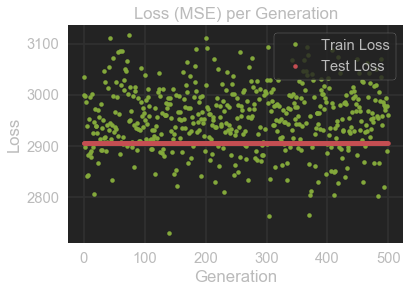

In [52]:
#visualizing the result
from jupyterthemes import jtplot
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='-')
%matplotlib inline
plt.plot(loss_vec, 'g.', label='Train Loss')
plt.plot(test_set_loss, 'r.', label='Test Loss')
plt.title('Loss (MSE) per Generation')
plt.legend(loc='upper right')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [55]:
#calculating the accuracy of the model

actual = np.array([x[0] for x in birth_data])
test_actual = actual[test_indices]
train_actual = actual[train_indices]
test_preds = [x[0] for x in sess.run(final_output, feed_dict={x_data: x_vals_test})]
train_preds = [x[0] for x in sess.run(final_output, feed_dict={x_data: x_vals_train})]
test_preds = np.array([1.0 if x < 2500.0 else 0.0 for x in test_preds])
train_preds = np.array([1.0 if x < 2500.0 else 0.0 for x in train_preds])

test_acc = np.mean([x == y for x, y in zip(test_preds, test_actual)])
train_acc = np.mean([x == y for x, y in zip(train_preds, train_actual)])
print('On predicting the category of low birthweight from regression output (<2500g):')
print('Test Accuracy: {}'.format(test_acc))
print('Train Accuracy: {}'.format(train_acc))

On predicting the category of low birthweight from regression output (<2500g):
Test Accuracy: 0.42105263157894735
Train Accuracy: 0.2847682119205298


In [57]:
new_data = np.array([[35, 185, 1., 0., 0., 0., 1.],
                     [18, 160, 0., 1., 0., 0., 1.]])
new_data_scaled = np.nan_to_num(normalize_columns(new_data, train_max, train_min))
new_logits = [x[0] for x in sess.run(final_output, feed_dict={x_data: new_data_scaled})]
new_preds = np.array([1.0 if x < 2500.0 else 0.0 for x in new_logits])

print('New Data Predictions: {}'.format(new_preds))

New Data Predictions: [1. 1.]
